In [1]:
import scienceplots
import matplotlib.pyplot as plt
import numpy as np

import cmbo
from IPython.display import display

from plot_stacked import *
from score_individual_objects import *

%load_ext autoreload
%autoreload 2

/Users/rstiskalek/Projects/CMBOlympics/venv_cmbo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = cmbo.utils.load_config("/Users/rstiskalek/Projects/CMBOlympics/scripts/config.toml")
data_MCXC = cmbo.io.load_mcxc_catalogue(cfg['paths']['MCXC_catalogue'])
data_eRASS = cmbo.io.load_erass_catalogue(cfg['paths']['eRASS_catalogue'])
data_tSZ = cmbo.io.read_Planck_cluster_catalog(cfg['paths']['Planck_tSZ_catalogue'])

Removing 94 MCXC entries with non-positive mass uncertainties.
Removing 1805 eRASS entries with M500 = -1.
Removing 1 eRASS entries with M500 > 3.00e+15 Msol.
Removing 559 Planck clusters with invalid redshifts (z <= 0 or NaN).


In [3]:
associations = cmbo.utils.load_associations("manticore", cfg)

Loaded 50 simulation realisations.
Identified 355 halo associations.
Halo signal datasets were not found in run_suite output.


In [12]:
# catalogue_matched, assoc_matched, pvals, distances, nmatched, ntot = cmbo.match.match_planck_catalog_to_associations(
    # data_tSZ, associations, match_threshold=0.05, mass_preference_threshold=0.01, use_median_mass=True, z_max=0.045)

# catalogue_matched, assoc_matched, pvals, distances, nmatched, ntot = cmbo.match.match_mcxc_catalog_to_associations(
    # data_MCXC, associations, match_threshold=0.05, mass_preference_threshold=0.01, use_median_mass=True, z_max=0.045)

catalogue_matched, assoc_matched, pvals, distances, nmatched, ntot = cmbo.match.match_erass_catalog_to_associations(
    data_eRASS, associations, match_threshold=0.05, mass_preference_threshold=None,
    use_median_mass=True, z_max=0.045, m500_min=1e14, matching_method="hungarian")


mu = assoc_matched.mean_log_mass
std = assoc_matched.std_log_mass

100%|██████████| 355/355 [00:03<00:00, 105.46it/s]

Position 5: min p-value = 2.211e-01
Position 6: min p-value = 1.089e-01
Position 11: min p-value = 1.211e-01
Position 12: min p-value = 5.056e-02
Position 13: min p-value = 6.666e-01
Position 17: min p-value = 1.763e-01
Position 20: min p-value = 8.388e-01
Position 22: min p-value = 1.195e-01
Position 23: min p-value = 1.000e+00
Position 32: min p-value = 6.123e-01
Position 33: min p-value = 7.069e-02
Position 34: min p-value = 3.105e-01
Position 35: min p-value = 6.781e-01
Position 36: min p-value = 9.060e-01
Position 41: min p-value = 1.771e-01
Position 43: min p-value = 9.238e-01
Position 45: min p-value = 1.002e-01
Position 46: min p-value = 3.315e-01
2025-11-19 11:36:28 Matched 26/47 objects (55.3%)


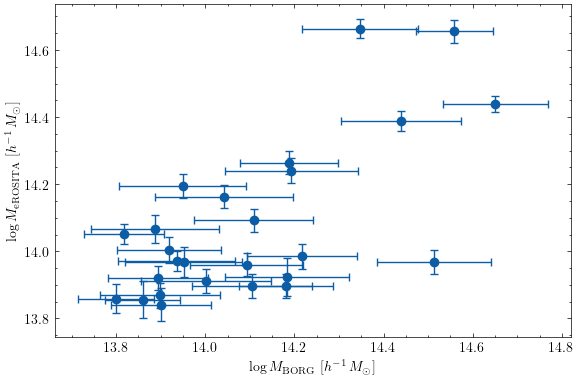

In [13]:
plt.figure(figsize=(6, 4))

x = np.array(mu)
xerr = std

y = np.log10(catalogue_matched["M500"] * 0.68)
yerr = catalogue_matched["eM500"] / (catalogue_matched["M500"] * np.log(10))

# y = np.log10(catalogue_matched["L500"] * 0.68)
# yerr = catalogue_matched["eL500"] / (catalogue_matched["L500"] * np.log(10))

# y = np.log10(catalogue_matched["Y500_scaled"])
# yerr = catalogue_matched["eY500_scaled"] / (catalogue_matched["Y500_scaled"] * np.log(10))


# y = np.log10(catalogue_matched['y5r500'])
# yerr = catalogue_matched['y5r500_err'] / (catalogue_matched['y5r500'] * np.log(10))

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3)

axmin, axmax = min(x.min(), y.min()), max(x.max(), y.max())
medx = np.median(x)
# plt.axline([medx, medx], slope=1, color='red', linestyle='--', label='1:1 line')

plt.xlabel(r'$\log M_{\rm BORG} ~ [h^{-1}\,M_\odot]$')
plt.ylabel(r'$\log M_{\rm eROSITA} ~ [h^{-1}\,M_\odot]$')
# plt.ylabel(r'$\log Y_{5R500} ~ [\mathrm{arcmin}^2]$')

plt.tight_layout()
# plt.savefig("/Users/rstiskalek/Downloads/mass_comparison_erass.png", dpi=450)
plt.show()

In [6]:
fitter = cmbo.utils.LinearRoxyFitter()
res = fitter.fit(x, y, xerr, yerr, method="mnr", x_pivot=14., y_pivot=14.)
fitter.print_summary()


Optimisation Results:
slope:	0.896811842918396
intercept:	-0.0009928038343787193
sig:	0.1278744488954544
mu_gauss:	0.08577495068311691
w_gauss:	0.2019340842962265

Running MCMC


sample: 100%|██████████| 5500/5500 [00:01<00:00, 3895.74it/s, 7 steps of size 4.46e-01. acc. prob=0.94]



                 mean       std    median      2.5%     97.5%     n_eff     r_hat
  intercept     -0.00      0.04     -0.00     -0.08      0.08   3602.10      1.00
   mu_gauss      0.09      0.05      0.09     -0.01      0.17   4484.35      1.00
        sig      0.14      0.04      0.14      0.07      0.21   2463.56      1.00
      slope      0.90      0.21      0.90      0.53      1.34   2264.65      1.00
    w_gauss      0.21      0.04      0.21      0.15      0.30   3873.08      1.00

Number of divergences: 0


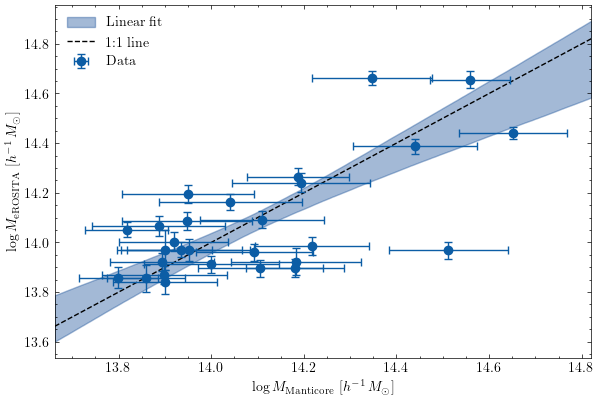

In [7]:
fig, ax = fitter.plot_fit(x, y, xerr, yerr, add_one_to_one=True)

ax.set_xlabel(r'$\log M_{\rm Manticore} ~ [h^{-1}\,M_\odot]$')
ax.set_ylabel(r'$\log M_{\rm eROSITA} ~ [h^{-1}\,M_\odot]$')

# fig.savefig("/Users/rstiskalek/Downloads/mass_relation_manticore_erass.png", dpi=450, bbox_inches='tight') )
display(fig)

In [11]:
cmbo.utils.correlation_with_errors(x, y, xerr, yerr, n_samples=10000, verbose=True)

100%|██████████| 10000/10000 [00:01<00:00, 5544.73it/s]


{'pearson': np.float64(0.6708891870681358),
 'pearson_err': np.float64(0.06662236462676091),
 'spearman': np.float64(0.5336617405582923),
 'spearman_err': np.float64(0.08955294172856351)}

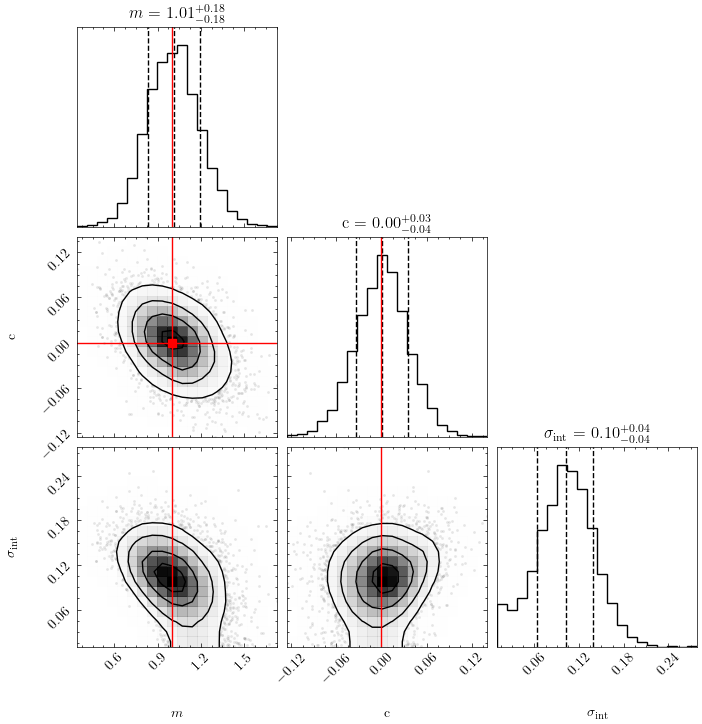

In [12]:
fig = fitter.plot_corner(truths=[1., 0, None])

display(fig)

In [13]:
fitter.get_slope_intercept_significance([1, 0])

(np.float64(0.9946496581303271), np.float64(0.0067057093598157005))